In [234]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [235]:
S = 100
v = 0.2
r = 0.02
y = 0.01
K = [95,100,105]
H = 90
T = 1/12

### Question 1

In [236]:
def EurapeanCall_DAO(S, sigma, r, y, K, H, T):
    a = (H/S) ** (2.0*(r-y)/sigma**2 - 1)
    b =  (H/S) ** (2.0*(r-y)/sigma**2 + 1)
    z1 = (np.log(S/K) + (r-y+sigma**2/2)*T) / np.sqrt(sigma**2 * T)
    z2 = z1 - np.sqrt(sigma**2 * T)
    z7 = (np.log(S*K/H**2) - (r-y-sigma**2/2)*T) / np.sqrt(sigma**2 * T)
    z8 = z7 - np.sqrt(sigma**2 * T)
    return S * np.exp(-y*T) * (norm.cdf(z1) - b*(1-norm.cdf(z8))) - K * np.exp(-r*T) * (norm.cdf(z2) - a*(1-norm.cdf(z7)))

In [237]:
gc = {}
for k in K:
    gc['%s'%k] = round(EurapeanCall_DAO(S,np.sqrt(v),r,y,k,H,T),5)
    print('European Call Down and Out Option price with K = %s is '%k, gc['%s'%k])

European Call Down and Out Option price with K = 95 is  7.29476
European Call Down and Out Option price with K = 100 is  4.9035
European Call Down and Out Option price with K = 105 is  3.06364


### Question 2

In [238]:
N  = 10000 # number of paths
DeltaT = 1/252
T  = 21/252

In [239]:
def SinglePath(dt, T, S, r, y, sigma, K, H):
    steps = int(np.floor(T / dt))    # the number of steps we have
    t = np.linspace(0, T, steps)  # create timeline
    X = np.random.randn(steps)  #simulate the change which is normally distributed
    ST = S
    for i in range(steps):
        ST = ST * np.exp((r - y - sigma**2) * dt + sigma * np.sqrt(dt) * X[i])
        if ST <= H:
            ST = 0.0
            break
    return ST


In [240]:
def EuropeanCall_DAO_MCS(Paths ,DeltaT, T, S, r, y, sigma, K, H):
    dt = DeltaT
    OptionPrice = []
    for i in range(Paths):
        OptionPrice.append(SinglePath(dt, T, S, r, y, sigma, K, H))
    
    payoff = np.array(OptionPrice) - K
    payoff[payoff<0] = 0
    value  = np.mean(payoff* np.exp(-r * T))
    
    return value

In [241]:
gd = {}
for k in K:
    gd['%s'%k] = round(EuropeanCall_DAO_MCS(N ,DeltaT, T, S, r, y, np.sqrt(v), k, H),5)
    print('European Call Down and Out Option price with K = %s is '%k, gd['%s'%k] )

European Call Down and Out Option price with K = 95 is  7.12153
European Call Down and Out Option price with K = 100 is  4.6845
European Call Down and Out Option price with K = 105 is  2.73309


### Question 3

In [242]:
H_BGK = H * np.exp(-0.5826*np.sqrt(v*DeltaT))
gd1 = {}
for k in K:
    gd1['%s'%k] = round(EurapeanCall_DAO(S,np.sqrt(v),r,y,k,H_BGK,T), 5)

In [243]:
gd1

{'95': 7.57388, '100': 5.03401, '105': 3.11945}

In [244]:
gd

{'95': 7.12153, '100': 4.6845, '105': 2.73309}

In [262]:
compare1 = np.array([['K = 95', 7.12153, 7.57388], ['K = 100', 4.6845, 5.03401], ['K = 105', 2.73309, 3.11945]])
compare1 = pd.DataFrame(compare1, columns=['Strike', 'call_MC', 'call_estimate'])
compare1[['call_MC', 'call_estimate']] = compare1[['call_MC', 'call_estimate']].apply(pd.to_numeric)
compare1

,Strike,call_MC,call_estimate
0,K = 95,7.12153,7.57388
1,K = 100,4.68450,5.03401
2,K = 105,2.73309,3.11945


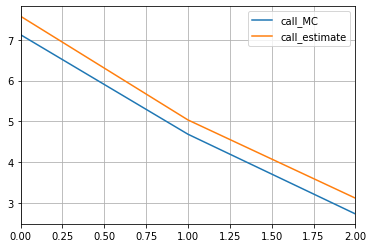

In [263]:
compare1.plot()
plt.grid()

### Question 4

In [247]:
N      = 10000
DeltaT = 1/2520
S      = 100
v      = 0.2
r      = 0.02
y      = 0.01
kappa  = 0.1
theta  = 0.15
sigma  = 0.2
lamb   = 0.03
rho    =-0.1

In [248]:
def SinglePath_Vol(dt, T, S, v, r, y, sigma):
    
    steps = int(np.floor(T / dt))    # the number of steps we have
    t  = np.linspace(0, T, steps+1)  # create timeline
    
    u1 = np.random.uniform(0,1,steps)
    u2 = np.random.uniform(0,1,steps)
    X1 = np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)
    X2 = np.sqrt(-2*np.log(u1))*np.sin(2*np.pi*u2)
    
    ST   = S
    vT   = v
    path = []
    for i in range(steps):
        
        ST = ST + (r - y)*ST * dt + np.sqrt(vT)*ST*np.sqrt(dt)*X1[i]
        vT = vT + (kappa*(theta-vT)-lamb*vT)*dt + sigma*np.sqrt(vT)*(rho*X1[i] + np.sqrt(1-rho**2)*X2[i])
        
        if vT<0:
            vT = kappa * sigma**2 * dt
        
        path.append(ST)
        
    return path

In [249]:
all_path = pd.DataFrame()
for i in range(10000):
    all_path = all_path.append(pd.DataFrame(SinglePath_Vol(DeltaT, T, S, v, r, y, sigma)).T)
all_path.index = np.arange(10000)

In [250]:
# check whether each path is out at 1/2520, keep the paths that are still active at T
out = all_path[all_path <= 90]
list1 = out.isnull().all(axis = 1).to_frame()
all_path_active = all_path[list1[0] == True]
all_path_active

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,99.463973,98.942800,99.788803,100.382816,100.379515,100.402139,100.037292,98.798799,99.168648,99.289011,...,104.771234,106.508994,106.406927,106.285065,104.915783,104.520639,102.754596,103.436240,103.068972,102.436860
1,100.216969,100.342452,100.415374,100.642045,100.941201,101.000065,102.114143,102.758481,102.361932,102.778603,...,101.869008,101.867942,101.850210,101.847798,101.850496,101.909399,101.576054,102.346054,102.107296,102.341226
2,100.256794,100.167511,99.771961,100.239958,100.463965,100.359029,100.464411,100.207581,99.124631,99.870176,...,108.381724,108.348244,108.427397,108.303084,108.299447,107.594234,108.371724,105.965353,108.015365,108.182910
3,98.063043,97.775452,97.100293,97.239947,97.617408,97.760306,97.697033,97.730920,97.729956,97.723853,...,97.814829,97.815468,97.809625,97.801981,97.803743,97.789244,97.806568,97.718952,97.722556,97.674851
4,98.851699,99.356999,99.356739,99.350991,99.356327,99.355525,99.356644,99.357014,99.356254,99.341876,...,100.513494,100.509823,100.508054,100.476351,100.503152,100.444238,100.222028,100.223040,100.227036,100.210128
6,100.394377,100.218741,100.353230,99.958451,100.300003,100.173758,99.545043,100.149561,100.336768,100.516107,...,100.847692,100.591742,100.378216,100.372899,100.379766,100.383229,100.363430,100.361069,100.361113,100.386103
7,99.339977,98.612522,98.897169,98.894137,98.892368,98.908130,99.016515,99.018326,99.022853,99.027865,...,98.447318,98.753982,98.755095,98.754050,98.809062,98.647030,99.006876,98.994997,99.454255,99.355844
8,101.058161,100.923362,100.255113,101.894844,102.069482,102.897050,102.825234,102.355748,102.491254,103.037293,...,112.586304,112.578009,112.717470,112.722130,112.716113,112.706248,112.982651,112.777724,112.557042,112.810234
9,101.397413,101.131974,102.770939,102.120466,102.996109,103.594700,102.359021,99.917384,100.341177,101.601529,...,106.462270,106.463877,106.468219,106.520174,106.520894,106.520740,106.524382,106.497063,106.515178,106.636880
10,100.781635,101.281380,100.545880,101.521324,101.780108,101.921088,102.248445,102.232863,102.228873,102.278127,...,100.699337,100.702101,100.715573,100.616772,100.621311,100.628746,100.635652,100.638152,100.621567,100.622721


In [251]:
def EuropeanCall_DAO_MCS_Vol(K, r, T):
      
    payoff = all_path_active[209] - K
    payoff[payoff<0] = 0
    value  = np.mean(payoff* np.exp(-r * T))
    
    return value

In [252]:
GC = {}
for k in K:
    GC['%s'%k] = round(EuropeanCall_DAO_MCS_Vol(k, r, T),5)
    print('European Call Down and Out Option price with K = %s is '%k, GC['%s'%k] )

European Call Down and Out Option price with K = 95 is  8.37134
European Call Down and Out Option price with K = 100 is  4.47459
European Call Down and Out Option price with K = 105 is  2.42056


### Question 5

In [253]:
new_path = all_path.iloc[:,9::10]
new_path

,9,19,29,39,49,59,69,79,89,99,...,119,129,139,149,159,169,179,189,199,209
0,99.289011,99.399761,99.066340,99.165567,99.145281,98.675749,98.769347,98.245620,99.278093,99.350955,...,99.999841,101.238014,99.927289,105.643892,105.672407,105.176646,105.068706,105.136957,105.286237,102.436860
1,102.778603,103.878740,103.806063,103.987230,104.537826,104.846279,104.512276,103.909435,103.487508,103.396943,...,103.354015,102.491665,101.136343,101.242525,101.641284,101.645106,101.338849,101.441083,101.835636,102.341226
2,99.870176,98.289632,98.349633,98.319689,98.388792,98.518325,97.643237,101.070731,100.398982,100.537304,...,107.903206,109.711126,107.432041,107.634652,107.704480,107.637626,108.362880,108.339631,108.380697,108.182910
3,97.723853,97.577433,97.587119,97.757908,97.608027,97.793452,96.537269,97.055000,96.998881,97.196663,...,97.105639,97.173282,97.186822,97.303561,97.347588,97.659979,97.699655,97.723425,97.808051,97.674851
4,99.341876,99.196435,99.260395,99.139210,99.237342,99.279025,99.220473,99.265627,99.353792,99.317237,...,96.195404,98.530792,98.846895,98.802328,99.385680,99.324748,99.245501,99.067797,100.516338,100.210128
5,98.350466,102.676880,110.177249,110.946013,99.623958,95.865244,93.345938,94.273653,94.371119,94.472560,...,93.615698,93.306093,89.762434,88.308744,88.408553,88.462453,88.238036,88.471724,88.528379,88.536510
6,100.516107,100.549994,100.573030,100.331460,102.563176,100.637009,100.888138,100.574213,100.525594,100.649279,...,100.374025,100.111457,100.133164,100.205139,100.221204,99.430672,100.424601,100.909744,100.880930,100.386103
7,99.027865,99.034664,99.345266,99.224954,100.698990,100.697410,100.351748,100.725091,99.532770,99.909415,...,99.724992,99.828494,99.388889,99.562051,98.545128,98.872507,99.578345,98.324832,98.312616,99.355844
8,103.037293,103.257451,103.227667,104.825760,106.674849,106.606236,106.501840,106.435696,106.143500,106.306605,...,106.486236,106.591648,106.678638,106.596935,106.677422,106.593216,105.914851,108.291706,112.587235,112.810234
9,101.601529,96.685796,104.549363,107.148441,106.781703,107.096279,107.291048,107.403430,107.322692,107.371926,...,107.207071,107.679363,107.592552,107.580709,107.476949,107.223149,107.028733,106.714807,106.680999,106.636880


In [254]:
# check whether each path is out at 1/252, keep the paths that are still active at T
new_out = new_path[new_path <= 90]
new_list = new_out.isnull().all(axis = 1).to_frame()
new_path_active = new_path[new_list[0] == True]
new_path_active

,9,19,29,39,49,59,69,79,89,99,...,119,129,139,149,159,169,179,189,199,209
0,99.289011,99.399761,99.066340,99.165567,99.145281,98.675749,98.769347,98.245620,99.278093,99.350955,...,99.999841,101.238014,99.927289,105.643892,105.672407,105.176646,105.068706,105.136957,105.286237,102.436860
1,102.778603,103.878740,103.806063,103.987230,104.537826,104.846279,104.512276,103.909435,103.487508,103.396943,...,103.354015,102.491665,101.136343,101.242525,101.641284,101.645106,101.338849,101.441083,101.835636,102.341226
2,99.870176,98.289632,98.349633,98.319689,98.388792,98.518325,97.643237,101.070731,100.398982,100.537304,...,107.903206,109.711126,107.432041,107.634652,107.704480,107.637626,108.362880,108.339631,108.380697,108.182910
3,97.723853,97.577433,97.587119,97.757908,97.608027,97.793452,96.537269,97.055000,96.998881,97.196663,...,97.105639,97.173282,97.186822,97.303561,97.347588,97.659979,97.699655,97.723425,97.808051,97.674851
4,99.341876,99.196435,99.260395,99.139210,99.237342,99.279025,99.220473,99.265627,99.353792,99.317237,...,96.195404,98.530792,98.846895,98.802328,99.385680,99.324748,99.245501,99.067797,100.516338,100.210128
6,100.516107,100.549994,100.573030,100.331460,102.563176,100.637009,100.888138,100.574213,100.525594,100.649279,...,100.374025,100.111457,100.133164,100.205139,100.221204,99.430672,100.424601,100.909744,100.880930,100.386103
7,99.027865,99.034664,99.345266,99.224954,100.698990,100.697410,100.351748,100.725091,99.532770,99.909415,...,99.724992,99.828494,99.388889,99.562051,98.545128,98.872507,99.578345,98.324832,98.312616,99.355844
8,103.037293,103.257451,103.227667,104.825760,106.674849,106.606236,106.501840,106.435696,106.143500,106.306605,...,106.486236,106.591648,106.678638,106.596935,106.677422,106.593216,105.914851,108.291706,112.587235,112.810234
9,101.601529,96.685796,104.549363,107.148441,106.781703,107.096279,107.291048,107.403430,107.322692,107.371926,...,107.207071,107.679363,107.592552,107.580709,107.476949,107.223149,107.028733,106.714807,106.680999,106.636880
10,102.278127,102.276092,101.755793,100.397587,100.541835,99.779093,100.067183,100.137620,98.827319,98.725215,...,99.489495,99.368619,99.495161,99.422928,99.524800,99.160091,99.139802,100.914539,100.694556,100.622721


In [255]:
def EuropeanCall_DAO_MCS_Vol_10(K,r,T):
    
    payoff = new_path_active[209] - K
    payoff[payoff<0] = 0
    value  = np.mean(payoff* np.exp(-r * T))
    
    return value

In [256]:
GD = {}
for k in K:
    GD['%s'%k] = round(EuropeanCall_DAO_MCS_Vol_10(k,r,T),5)
    print('European Call Down and Out Option price with K = %s is '%k, GD['%s'%k] )

European Call Down and Out Option price with K = 95 is  8.43224
European Call Down and Out Option price with K = 100 is  4.58707
European Call Down and Out Option price with K = 105 is  2.5503


### Question 6

In [266]:
H_BGK = H * np.exp(-0.5826*np.sqrt(v*DeltaT))
out_app = all_path[all_path <= H_BGK]
list_app = out_app.isnull().all(axis = 1).to_frame()
all_path_active_app = all_path[list_app[0] == True]
all_path_active_app

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,99.463973,98.942800,99.788803,100.382816,100.379515,100.402139,100.037292,98.798799,99.168648,99.289011,...,104.771234,106.508994,106.406927,106.285065,104.915783,104.520639,102.754596,103.436240,103.068972,102.436860
1,100.216969,100.342452,100.415374,100.642045,100.941201,101.000065,102.114143,102.758481,102.361932,102.778603,...,101.869008,101.867942,101.850210,101.847798,101.850496,101.909399,101.576054,102.346054,102.107296,102.341226
2,100.256794,100.167511,99.771961,100.239958,100.463965,100.359029,100.464411,100.207581,99.124631,99.870176,...,108.381724,108.348244,108.427397,108.303084,108.299447,107.594234,108.371724,105.965353,108.015365,108.182910
3,98.063043,97.775452,97.100293,97.239947,97.617408,97.760306,97.697033,97.730920,97.729956,97.723853,...,97.814829,97.815468,97.809625,97.801981,97.803743,97.789244,97.806568,97.718952,97.722556,97.674851
4,98.851699,99.356999,99.356739,99.350991,99.356327,99.355525,99.356644,99.357014,99.356254,99.341876,...,100.513494,100.509823,100.508054,100.476351,100.503152,100.444238,100.222028,100.223040,100.227036,100.210128
6,100.394377,100.218741,100.353230,99.958451,100.300003,100.173758,99.545043,100.149561,100.336768,100.516107,...,100.847692,100.591742,100.378216,100.372899,100.379766,100.383229,100.363430,100.361069,100.361113,100.386103
7,99.339977,98.612522,98.897169,98.894137,98.892368,98.908130,99.016515,99.018326,99.022853,99.027865,...,98.447318,98.753982,98.755095,98.754050,98.809062,98.647030,99.006876,98.994997,99.454255,99.355844
8,101.058161,100.923362,100.255113,101.894844,102.069482,102.897050,102.825234,102.355748,102.491254,103.037293,...,112.586304,112.578009,112.717470,112.722130,112.716113,112.706248,112.982651,112.777724,112.557042,112.810234
9,101.397413,101.131974,102.770939,102.120466,102.996109,103.594700,102.359021,99.917384,100.341177,101.601529,...,106.462270,106.463877,106.468219,106.520174,106.520894,106.520740,106.524382,106.497063,106.515178,106.636880
10,100.781635,101.281380,100.545880,101.521324,101.780108,101.921088,102.248445,102.232863,102.228873,102.278127,...,100.699337,100.702101,100.715573,100.616772,100.621311,100.628746,100.635652,100.638152,100.621567,100.622721


In [267]:
def EuropeanCall_DAO_MCS_Vol_app(K, r, T):
      
    payoff = all_path_active_app[209] - K
    payoff[payoff<0] = 0
    value  = np.mean(payoff* np.exp(-r * T))
    
    return value

In [268]:
GD1 = {}
for k in K:
    GD1['%s'%k] = round(EuropeanCall_DAO_MCS_Vol_app(k, r, T), 5)

In [269]:
GD

{'95': 8.43224, '100': 4.58707, '105': 2.5503}

In [270]:
GD1

{'95': 8.31787, '100': 4.45327, '105': 2.41533}

In [271]:
compare2 = np.array([['K = 95', 8.43224, 8.31787], ['K = 100', 4.58707, 4.45327], ['K = 105', 2.5503, 2.41533]])
compare2 = pd.DataFrame(compare2, columns=['Strike', 'call_SVM_MC', 'call_SVM_estimate'])
compare2[['call_SVM_MC', 'call_SVM_estimate']] = compare2[['call_SVM_MC', 'call_SVM_estimate']].apply(pd.to_numeric)
compare2

,Strike,call_SVM_MC,call_SVM_estimate
0,K = 95,8.43224,8.31787
1,K = 100,4.58707,4.45327
2,K = 105,2.55030,2.41533


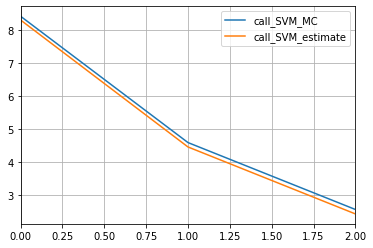

In [272]:
compare2.plot()
plt.grid()